# Load and process

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

### Note: For analysis, please read the report. This notebook has limited text, and is a consolidation of our code, not our analysis.

# BEAUTY DATASET

We will first perform our analysis on the beauty dataset, and later on the other categories 
#### Read file
We want to make sure we have the right category of reviews, and only those that have enough heplfulness votes to be meaningful.

In [30]:
df = pd.read_json('data/beauty_final.json', lines=True)
df = df[df.product_category == 'Beauty']
df = df[df.total_votes > 10]

#### Add useful columns

In [31]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]

#### Stats

In [32]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
31634

helpful count
22846

not helpful count
8788

average helpfulness
0.8361731048870983

average length of helpful review
708.8703055239429

average length of not helpful review
638.8099681383706


# Analyse various factors vs helpfulness
Now we will explore the data to see if different columns of our dataset affect the helpfulness of a review in a meaningful way.

#### Review length

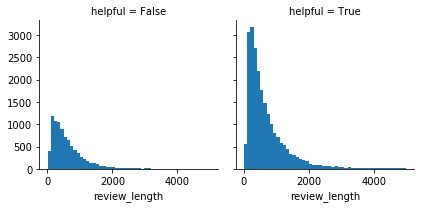

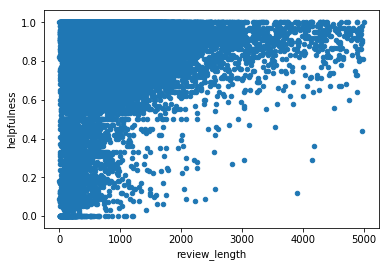

In [33]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

df.plot.scatter(x='review_length',y='helpfulness')

Immediately, we can see that helpful reviews reach much longer lengths than unhelpful ones. However, we have to keep in mind that there are many more helpful reviews than unhelpful.
#### Star rating

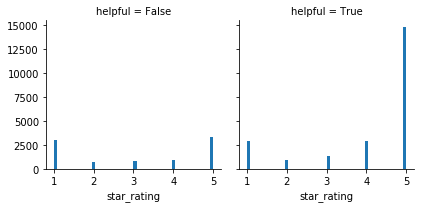

In [34]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Verified purchase

In [35]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {:.2f}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {:.2f}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.84
avg helpfulness of unverified purchases: 0.82


#### Review Date

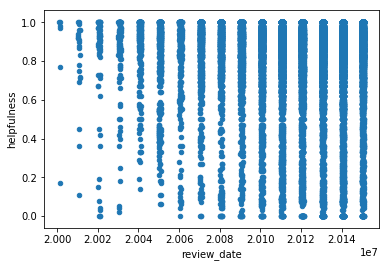

In [36]:
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

# Predicting using Naive Bayes

In [37]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and len(word) > 3]

In [38]:
X = df['review_body']
Y = df['helpful']

In [39]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [40]:
X = bow_transformer.transform(X)

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [42]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 593 2086]
 [ 658 6154]]


              precision    recall  f1-score   support

       False       0.47      0.22      0.30      2679
        True       0.75      0.90      0.82      6812

   micro avg       0.71      0.71      0.71      9491
   macro avg       0.61      0.56      0.56      9491
weighted avg       0.67      0.71      0.67      9491



#### ComplementNB 

In [44]:
cnb = ComplementNB()
cnb.fit(X_train, Y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [45]:
preds = cnb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 833 1846]
 [ 984 5828]]


              precision    recall  f1-score   support

       False       0.46      0.31      0.37      2679
        True       0.76      0.86      0.80      6812

   micro avg       0.70      0.70      0.70      9491
   macro avg       0.61      0.58      0.59      9491
weighted avg       0.67      0.70      0.68      9491



Because the results of ComplementNB are not better, we will only use MultivariateNB from now on.

#### Manual examination

In [46]:
df[df.helpfulness > 0.1].sort_values('helpfulness').head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
34883,15440872,4,Beauty,B00R5B3POA,I just received these items yesterday so it is...,20150311,R6XKZE43YCMDX,1,35,Y,0.11,False,84


In [47]:
mid_review = df['review_body'][2808]
mid_review_transformed = bow_transformer.transform([mid_review])
print("predicted helpful: {0}, actual helpfulness: {1}".format(nb.predict(mid_review_transformed)[0],df['helpfulness'][2808]))

predicted helpful: False, actual helpfulness: 0.11


#### Most reviewed products

In [48]:
df.product_id.value_counts(ascending=False).head(6)

B00LFT0CEO    80
B002W2HIYA    61
B00IAMTLS2    56
B002VBE6N8    52
B00005JHWB    51
B00064LO3C    50
Name: product_id, dtype: int64

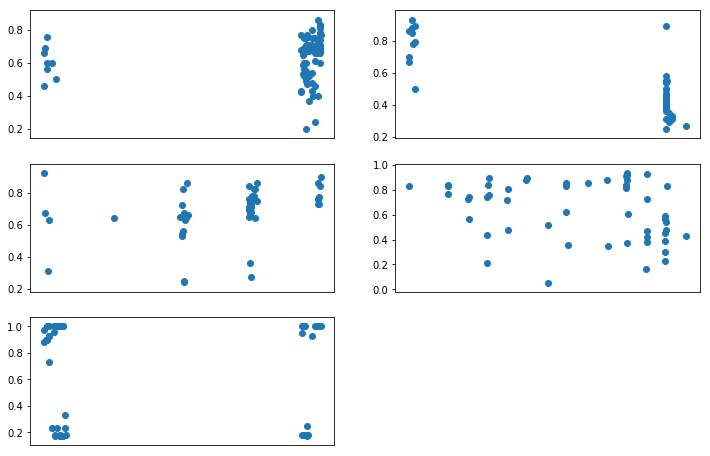

In [49]:
df_1 = df[df.product_id == 'B00LFT0CEO']
df_2 = df[df.product_id == 'B002W2HIYA']
df_3 = df[df.product_id == 'B00IAMTLS2']
df_4 = df[df.product_id == 'B00064LO3C']
df_5 = df[df.product_id == 'B002VBE6N8']
df_6 = df[df.product_id == 'B00005JHWB']

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)

# Using the Beauty classifier on Automotive dataset

In [50]:
df_a = pd.read_json('data/auto_final.json', lines=True)

In [51]:
df_a = df_a.dropna()

df_a['helpfulness'] = (df_a.helpful_votes / df_a.total_votes).round(2)
df_a['helpful'] = df_a.helpfulness > 0.8

df_a['review_length'] = df_a['review_body'].apply(len)
df_a = df_a[df_a.review_length <= 5000]

In [52]:
X_a = df_a['review_body']
Y_a = df_a['helpful']

In [ ]:
X_a = bow_transformer.transform(X_a)

In [ ]:
X_a_train, X_a_test, Y_a_train, Y_a_test = train_test_split(X_a, Y_a, test_size=0.3, random_state=101)

In [ ]:
preds = nb.predict(X_a_test)

print(confusion_matrix(Y_a_test, preds))
print('\n')
print(classification_report(Y_a_test, preds))

# BABY DATASET

In [11]:
df = pd.read_json('data/baby_final.json', lines=True)
df = df[df.product_category == 'Baby']
df = df[df.total_votes > 5]

#### Add useful columns

In [13]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]

#### Stats

In [4]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
11069

helpful count
7269

not helpful count
3800

average helpfulness
0.812534104255115

average length of helpful review
943.5077727335259

average length of not helpful review
814.2894736842105


# Analyse factors vs helpfulness

#### Review length

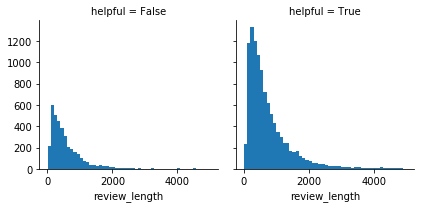

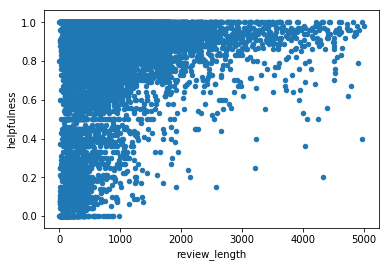

In [16]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

df.plot.scatter(x='review_length',y='helpfulness')

#### Star rating

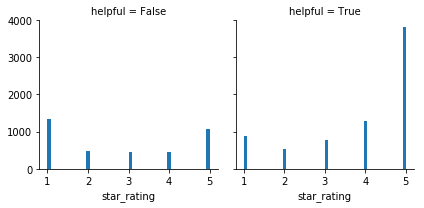

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Review Date

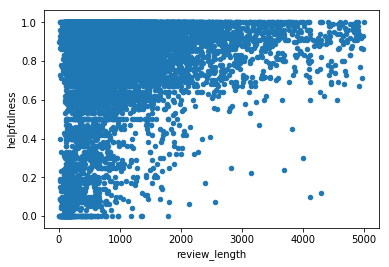

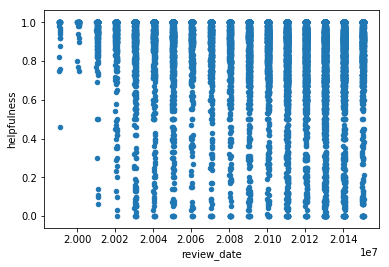

In [22]:
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.8095489392048497
avg helpfulness of unverified purchases: 0.8156007326007293


# Predicting using Naive Bayes

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [13]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 359  748]
 [ 317 1897]]


              precision    recall  f1-score   support

       False       0.53      0.32      0.40      1107
        True       0.72      0.86      0.78      2214

   micro avg       0.68      0.68      0.68      3321
   macro avg       0.62      0.59      0.59      3321
weighted avg       0.66      0.68      0.65      3321



# AUTOMOTIVES DATASET

In [14]:
df = pd.read_json('data/auto_final.json', lines=True)
df = df[df.product_category == 'Automotive']
df = df[df.total_votes > 5]

#### Add useful columns

In [15]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]

#### Stats

In [4]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
14557

helpful count
10821

not helpful count
3736

average helpfulness
0.8333186782990832

average length of helpful review
763.8600868681268

average length of not helpful review
598.2668629550321


# Analyse factors vs helpfulness

#### Review length

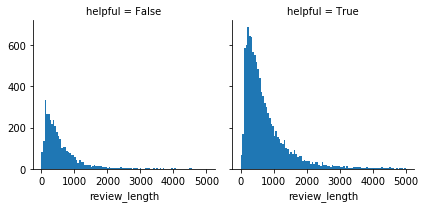

In [23]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=100)

#### Star rating

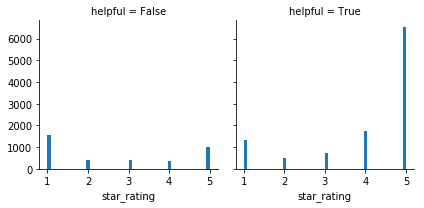

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

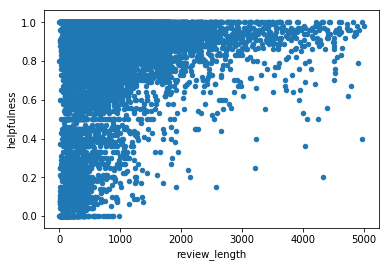

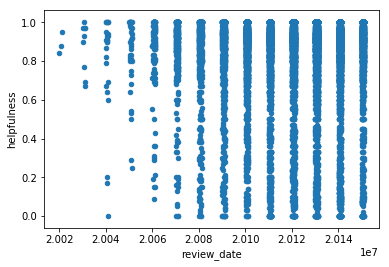

In [24]:
df.plot.scatter(x='review_length',y='helpfulness')
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.8414531317494457
avg helpfulness of unverified purchases: 0.8017437961100016


# Predicting using Naive Bayes

In [8]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and len(word) > 3]

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [13]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 277  804]
 [ 247 3040]]


              precision    recall  f1-score   support

       False       0.53      0.26      0.35      1081
        True       0.79      0.92      0.85      3287

   micro avg       0.76      0.76      0.76      4368
   macro avg       0.66      0.59      0.60      4368
weighted avg       0.73      0.76      0.73      4368



# ELECTRONICS DATASET

In [3]:
df = pd.read_json('data/electronics_final.json', lines=True)
df = df[df.product_category == 'Electronics']
df = df[df.total_votes > 5]

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase
0,51005725,70,Electronics,B00001W0DC,"First, a direct product link for the MDR-V150:...",2008-06-17,R5M7VQVV19FAQ,1,75,N


#### Add useful columns

In [4]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,51005725,70,Electronics,B00001W0DC,"First, a direct product link for the MDR-V150:...",2008-06-17,R5M7VQVV19FAQ,1,75,N,0.93,True,1600


#### Stats

In [5]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
21070

helpful count
13674

not helpful count
7396

average helpfulness
0.7819501661129379

average length of helpful review
1169.928038613427

average length of not helpful review
796.5996484586262


# Analyse factors vs helpfulness

#### Review length

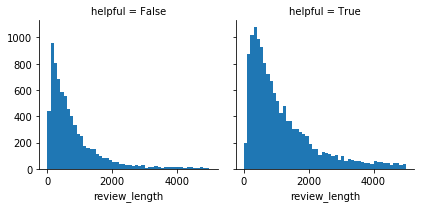

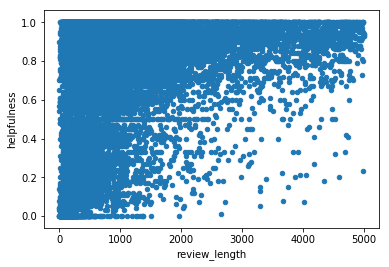

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

df.plot.scatter(x='review_length',y='helpfulness')

#### Star rating

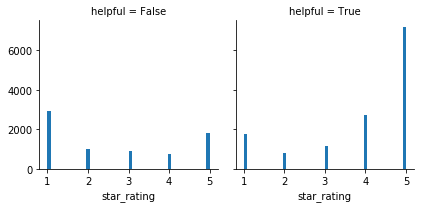

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Review Date

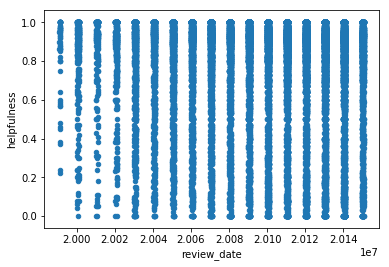

In [8]:
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.7913079183955624
avg helpfulness of unverified purchases: 0.77055777731003


# Predicting using Naive Bayes

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [13]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 722 1452]
 [ 472 3675]]


              precision    recall  f1-score   support

       False       0.60      0.33      0.43      2174
        True       0.72      0.89      0.79      4147

   micro avg       0.70      0.70      0.70      6321
   macro avg       0.66      0.61      0.61      6321
weighted avg       0.68      0.70      0.67      6321



# BOOKS DATASET
This dataset we will do things differently, and only consider reviews at the exteme sides of helpfulness.

#### Read file

In [ ]:
df = pd.read_json('data/books_final.json', lines=True)
df = df[df.product_category == 'Books']
df = df[df.total_votes > 5]

#### Add useful columns

In [28]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]

#### Stats

In [12]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
51079

helpful count
28723

not helpful count
22356

average helpfulness
0.6053810763718815

average length of helpful review
1118.858963200223

average length of not helpful review
498.65991232778674


#### Only extreme reviews

In [ ]:
df = df[(df.helpfulness < 0.2) | (df.helpfulness > 0.99)]
df['helpful'] = df.helpfulness > 0.8

#### Extreme review stats

In [ ]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

# Analyse factors vs helpfulness

#### Review length

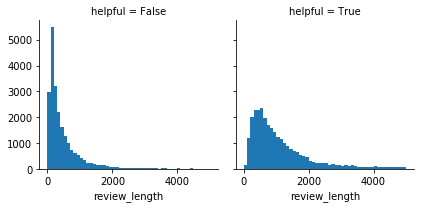

In [13]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

#### Star rating

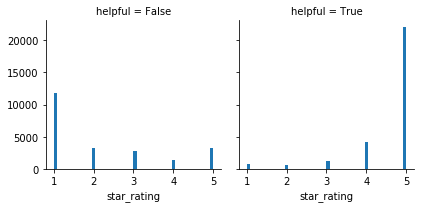

In [14]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Verified purchase

# Predicting using Naive Bayes

In [18]:
X = df['review_body']
Y = df['helpful']

In [19]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [20]:
X = bow_transformer.transform(X)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [22]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[4181 2512]
 [ 523 8108]]


              precision    recall  f1-score   support

       False       0.89      0.62      0.73      6693
        True       0.76      0.94      0.84      8631

   micro avg       0.80      0.80      0.80     15324
   macro avg       0.83      0.78      0.79     15324
weighted avg       0.82      0.80      0.79     15324



# CUSTOMERS
This is the dataset with the customers who leave a large number of reviews. We will do analysis to see if there is a common pattern in their behaviour.

In [2]:
df = pd.read_json('data/customers_final.json', lines=True)
df = df[df.total_votes > 5]

In [3]:
df = df.dropna()

df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)
df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,6935058,50,Mobile_Apps,B00HBWVVN0,Awesome!,2015-08-11,R1QTCWCGNJVJA0,3,71,Y,0.7,False,8


#### Stats

In [5]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
219566

helpful count
166681

not helpful count
52885

average helpfulness
0.8271020558741954

average length of helpful review
1952.7827826806895

average length of not helpful review
1573.249579275787


#### Plots

In [22]:
df.customer_id.value_counts(ascending=False).head(10)

50122160    1103
50881246     624
52496677     584
52500542     520
52615377     468
13161706     443
50199793     388
44834233     385
50732546     385
50913245     374
Name: customer_id, dtype: int64

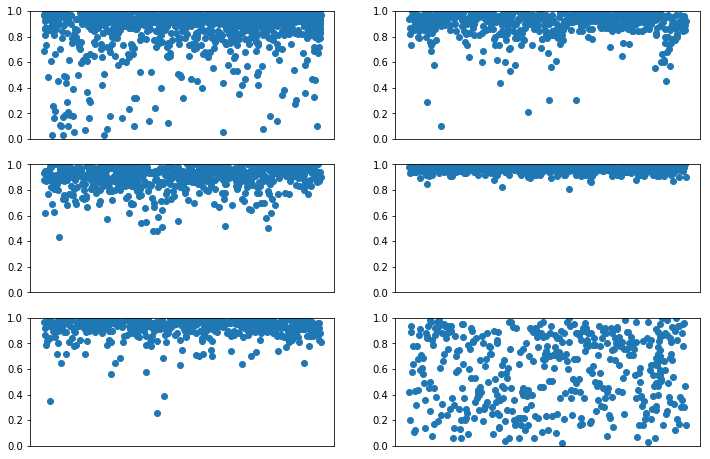

In [34]:
df_1 = df[df.customer_id == 50122160]
df_2 = df[df.customer_id == 50881246]
df_3 = df[df.customer_id == 52496677]
df_4 = df[df.customer_id == 52500542]
df_5 = df[df.customer_id == 52615377]
df_6 = df[df.customer_id == 13161706]
df_7 = df[df.customer_id == 50199793]
df_8 = df[df.customer_id == 44834233]
df_9 = df[df.customer_id == 50732546]
df_10 = df[df.customer_id == 50913245]

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (0, 1))
ax4 = plt.subplot2grid(gridsize, (1, 1))
ax5 = plt.subplot2grid(gridsize, (2, 0))
ax6 = plt.subplot2grid(gridsize, (2, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])
    ax.set_ylim(0, 1)

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)